In [1]:
import twitter

In [2]:
def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
    # for more information on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'OBxRwRFiGNfaWcQuhPMClolHb'
    CONSUMER_SECRET = '36udcF8jGmaOeNy1zNV0tcPepm9ehXBKCbZyRmHFKTPiB12Dqo'
    OAUTH_TOKEN = '1087488903270072321-LfBjp3yuvFq55FxKWzNoD4FkU85e6K'
    OAUTH_TOKEN_SECRET = 'u7kCfRD1vVon2YNRDhhJpAPCHmACH92SN6oQ2YEHFNUF7'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    
screen_name = 'edmundyu1001'

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print(twitter_api)


In [6]:

import sys
import time
from urllib.error import URLError
from http.client import BadStatusLine
import json

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
    
        # See https://developer.twitter.com/en/docs/basics/response-codes
        # for common codes
    
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429: 
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered {0} Error. Retrying in {1} seconds'                  .format(e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("BadStatusLine encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise


In [7]:
from functools import partial
from sys import maxsize as maxint

def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint, followers_limit=maxint):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None),     "Must have screen_name or user_id, but not both"
    
    # See http://bit.ly/2GcjKJP and http://bit.ly/2rFz90N for details
    # on API parameters
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, 
                              count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, 
                                count=5000)

    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [
                    [get_friends_ids, friends_limit, friends_ids, "friends"], 
                    [get_followers_ids, followers_limit, followers_ids, "followers"]
                ]:
        
        if limit == 0: continue
        
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
        
            print('Fetched {0} total {1} ids for {2}'.format(len(ids), label, (user_id or screen_name)),file=sys.stderr)
        
            # XXX: You may want to store data during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
        
            if len(ids) >= limit or response is None:
                break

    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

# Sample usage

#twitter_api = oauth_login()

friends_ids, followers_ids = get_friends_followers_ids(twitter_api, 
                                                       screen_name="edmundyu1001", 
                                                       friends_limit=10, 
                                                       followers_limit=10)

print(friends_ids)
print(followers_ids)


Fetched 127 total friends ids for edmundyu1001


[1344951, 954066971892600833, 954190672650752000, 768231590187134976, 3832106173, 724099177177718784, 866321645002162177, 76966092, 2338658462, 1933042237]
[3116713424, 120031673, 768231590187134976, 954190672650752000, 76966092, 2338658462, 1933042237, 2749167177, 14645160, 743856512]


Fetched 70 total followers ids for edmundyu1001


In [8]:
def get_reciprocal_friends(twitter_api, screen_name):
    friends_response = make_twitter_request(twitter_api.friends.ids, screen_name=screen_name, count = 5000)
    followers_response = make_twitter_request(twitter_api.followers.ids, screen_name=screen_name, count = 5000)
    friends, followers = [], []
    if friends_response: friends = friends_response["ids"]
    if followers_response: followers = followers_response["ids"]

    reciprocal_friends = set(friends) & set(followers)
    res = list(reciprocal_friends)
    return res

reciprocal_friends = get_reciprocal_friends(twitter_api, screen_name)
print(reciprocal_friends)

[768231590187134976, 954190672650752000, 743856512, 1960131073, 2821436679, 3240878475, 553075088, 1354838418, 144875027, 34376087, 2338658462, 2902727583, 590208162, 14476451, 88282022, 14645160, 274208425, 3959267115, 363160107, 2836876335, 609187760, 5548212, 276569910, 54113975, 2774659128, 78419512, 3020481083, 3832106173, 1933042237, 24733117, 36032320, 17596353, 243077314, 2749167177, 68792137, 130992073, 76966092, 76376525, 104542286, 412174671, 5514192, 370978131, 1877474773, 17881816, 1877180376, 1529638232, 86310874, 2342319324, 568166877, 31407357, 2802888287, 3130962657, 817545704, 2383040108, 1964709229, 3249140718, 577403888, 17129715, 325748468, 2950692597, 719423990, 113435127, 2843793653, 96032763, 430492796, 16807677]


In [9]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
   
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None),     "Must have screen_names or user_ids, but not both"
    
    items_to_info = {}

    items = screen_names or user_ids
    
    while len(items) > 0:

        # Process 100 items at a time per the API specifications for /users/lookup.
        # See http://bit.ly/2Gcjfzr for details.
        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]

        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, 
                                            screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, 
                                            user_id=items_str)
    
        for user_info in response:
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info
            else: # user_ids
                items_to_info[user_info['id']] = user_info

    return items_to_info

In [10]:
def popular_users(users_list, num):
    if num > len(users_list): 
        return users_list
    # get all reciprocal_friends' profiles
    cur_response = get_user_profile(twitter_api, user_ids=users_list)
    # sort by followers_count
    sortedList = sorted(cur_response.items(), key=lambda k: k[1]['followers_count'],reverse=True)
    # return the first num elements
    return [i[0] for i in sortedList[:num]]

#lists = list(reciprocal_friends)
popular_users(reciprocal_friends, 5)

[17881816, 1933042237, 14645160, 76966092, 5514192]

In [11]:
friends_list = list(reciprocal_friends)
ids = popular_users(friends_list, 5)
print(ids)

[17881816, 1933042237, 14645160, 76966092, 5514192]


In [31]:
def crawl_followers_friends(twitter_api, screen_name, max_depth):
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends_list = get_reciprocal_friends(twitter_api, screen_name)
    next_reciprocal_queue = popular_users(friends_list, 5)
    res = [(seed_id, i) for i in next_reciprocal_queue]
    
    depth = 1
    while depth < max_depth:
        depth += 1
        (reciprocal_queue, next_reciprocal_queue) = (next_reciprocal_queue, [])
        names = make_twitter_request(twitter_api.users.lookup, 
                                            user_id=reciprocal_queue)
        for name in names:
            #seed_name = str(twitter_api.users.show(user_id=friend_id)['screen_name'])
            cur_list = get_reciprocal_friends(twitter_api, name)
            new_friends = popular_users(cur_list, 5)
            next_reciprocal_queue += new_friends
            
            res += [(friend_id, i) for i in new_friends]
        
    print("{} edges included".format(len(res)))
    return res

In [29]:
def crawl_followers_friends2(twitter_api, screen_name):
    response = make_twitter_request(twitter_api.followers.ids, screen_name=screen_name, count=5) 
    ids = next_queue = response["ids"]
    level = 1
    max_level = 3
    while level < max_level: 
        level += 1
        (queue, next_queue) = (next_queue, []) 
        for id in queue:
            response = make_twitter_request(twitter_api.followers.ids, user_id=id, count=5)
            if response: next_queue += response["ids"] 
        ids += next_queue
    return ids

In [ ]:
edges = crawl_followers_friends(twitter_api,screen_name,2)
print(edges)

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


In [17]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()

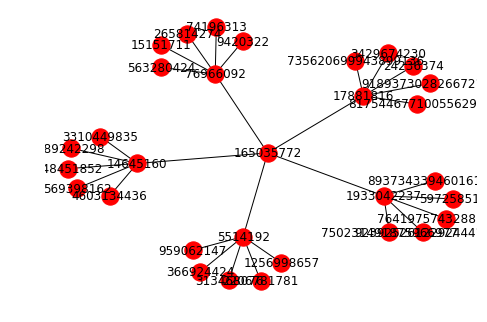

In [21]:
G.add_edges_from(edges,color='red')
nx.draw(G, with_labels=True)
plt.show()

In [26]:
def test(twitter_api, screen_name):
    response = make_twitter_request(twitter_api.followers.ids, screen_name=screen_name, count=2) 
    ids = next_queue = response["ids"]
    level = 1
    max_level = 3
    while level < max_level: 
        level += 1
        (queue, next_queue) = (next_queue, []) 
        for id in queue:
            response = make_twitter_request(twitter_api.followers.ids, user_id=id, count = 2)
            if response: next_queue += response["ids"] 
        ids += next_queue
    return ids
test(twitter_api, screen_name)

Encountered 401 Error (Not Authorized)


[3116713424,
 120031673,
 1580157296,
 56952328,
 562376481,
 3116713424,
 340929468,
 2352792564]